In [72]:
!pip install -q -U kaggle_environments

In [73]:
import numpy as np
import pandas as pd
import random
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate

import warnings
warnings.filterwarnings("ignore")

____
## Предисловие перед выполнением.
### Данный ноутбук смог запуститься только под google collab, kaggle_environments беспрестанно уходил в коллизию под всеми ядрами и в VS Code и в Anaconda Nav.
___

In [74]:
# Инициализируем встроенных агентов из API списком, добавляя к нему самописных
agent_names = [
    "rock",
    "paper",
    "scissors",
    "copy_opponent",
    "reactionary",
    "counter_reactionary",
    "statistical",
]

В данной стратегии агент повторяет предыдущее действие противника

In [75]:
%%writefile submission.py
def copy_opponent_agent (observation, configuration):
    if observation.step > 0:
        opp_hand = observation.lastOpponentAction
        return (opp_hand + 1) % 3
    else:
        return 1

Overwriting submission.py


In [76]:
agent_names.append("submission.py")

В данной стратегии игрок повторяет последний ход соперника с фиксированным сдвигом. Например, если сдвиг равен одному, и соперник поставил Камень, мы ставим Камень + 1, то есть Бумагу, если соперник поставил Бумагу, мы ставим Ножницы и так далее. В этой стратегии мы предполагаем, что если соперник играет постоянно, мы выигрываем всегда. Сдвиг может быть равен 1, 2 или 0 (затем повторяется). Для сдвига = 0 стратегия аналогична отражению хода соперника.

Реализация добавляет сдвиг 1, 2 или 0 к последнему действию наблюдаемого соперника.

Примечание: мы также можем параметризовать реализацию, чтобы предоставить сдвиг в качестве параметра здесь.

In [77]:
%%writefile mirror_opponent.py

def mirror_opponent_agent(observation, configuration):
    if observation.step > 0:
        return observation.lastOpponentAction
    else:
        return 0

Overwriting mirror_opponent.py


In [78]:
agent_names.append("mirror_opponent.py")

In [79]:
%%writefile mirror_shift_opponent_2.py

def mirror_shift_opponent_agent_2(observation, configuration):
    if observation.step > 0:
        return (observation.lastOpponentAction + 2) % 3
    else:
        return 0

Overwriting mirror_shift_opponent_2.py


In [80]:
agent_names.append("mirror_shift_opponent_2.py")

In [81]:
%%writefile mirror_shift_opponent_0.py

def mirror_shift_opponent_agent_0(observation, configuration):
    if observation.step > 0:
        return (observation.lastOpponentAction)
    else:
        return 0

Overwriting mirror_shift_opponent_0.py


In [82]:
agent_names.append("mirror_shift_opponent_0.py")

In [83]:
%%writefile mirror_shift_opponent_1.py

def mirror_shift_opponent_agent_1(observation, configuration):
    if observation.step > 0:
        return (observation.lastOpponentAction + 1) % 3
    else:
        return 0

Overwriting mirror_shift_opponent_1.py


In [84]:
agent_names.append("mirror_shift_opponent_1.py")

В этой стратегии игрок создает простую цепь Маркова с 3 состояниями и матрицей переходов размером 3x3. Она инициализируется равномерными вероятностями, а затем обучается на основе данных для предсказания следующего хода соперника. Реализация основана на данном ядре: RPS: Opponent Transition Matrix (соревнование KAGGLE)

In [85]:
%%writefile transition_matrix.py

import numpy as np
import pandas as pd
import random

T = np.zeros((3, 3))
P = np.zeros((3, 3))

# action_opponent_1 : action of the opponent with 1 step before
# action_opponent_2 : action of the opponent with 2 steps before

action_opponent_1, action_opponent_2 = None, None

def transition_matrix_agent(observation, configuration):
    global T, P, action_opponent_1, action_opponent_2
    if observation.step > 1:
        action_opponent_1 = observation.lastOpponentAction
        T[action_opponent_2, action_opponent_1] += 1
        P = np.divide(T, np.maximum(1, T.sum(axis=1)).reshape(-1, 1))
        action_opponent_2 = action_opponent_1
        if np.sum(P[action_opponent_1, :]) == 1:
            return int((np.random.choice(
                [0, 1, 2],
                p=P[action_opponent_1, :]
            ) + 1) % 3)
        else:
            return int(np.random.randint(3))

    else:
        if observation.step == 1:
            action_opponent_2 = observation.lastOpponentAction
        return int(np.random.randint(3))

Overwriting transition_matrix.py


In [86]:
agent_names.append("transition_matrix.py")

---
---

Предподготовка соревнования

In [87]:
# Зададим попарную комбинацию агентов
agents_pairs = list(itertools.combinations(agent_names, 2))

# Зададим матрицу взаимодействий
num_agents = len(agent_names)
interactions_matrix = np.zeros((num_agents, num_agents))
interactions_matrix = pd.DataFrame(interactions_matrix)

# Проименуем оси
interactions_matrix = interactions_matrix.set_axis(agent_names, axis=0)
interactions_matrix = interactions_matrix.set_axis(agent_names, axis=1)


In [88]:
# Создадим функцию в которую будут отправляться пары агентов,
# а рузультат будет записываться в словарь попарных итогов
def trials(agent_1, agent_2, iterations=100):

    result = dict()

    ag_1 = agent_1
    ag_2 = agent_2

    result_score = evaluate(
        "rps", #environment to use - no need to change
        agents=[ag_1, ag_2], #agents to evaluate
        configuration={"episodeSteps": iterations} #number of episodes
    )

    # Результатом функции будет словарь с парой взаимодействия
    # агентов ключами в котором будет кортеж из имен агентов
    result[(agent_1, agent_2)] = result_score[0][0]
    result[(agent_2, agent_1)] = result_score[0][1]

    return result

In [89]:
# Пробежим по парам соревнующихся
# добавляя результаты в таблицу
for i in agents_pairs:
    trial = trials(i[0], i[1])
    trial.keys()
    trial_1 = list(trial.keys())[0]
    trial_res_1 = list(trial.values())[0]

    trial_2 = list(trial.keys())[1]
    trial_res_2 = list(trial.values())[1]

    interactions_matrix.loc[trial_1[0], trial_1[1]] = \
        trial_res_1
    interactions_matrix.loc[trial_2[0], trial_2[1]] = \
        trial_res_2

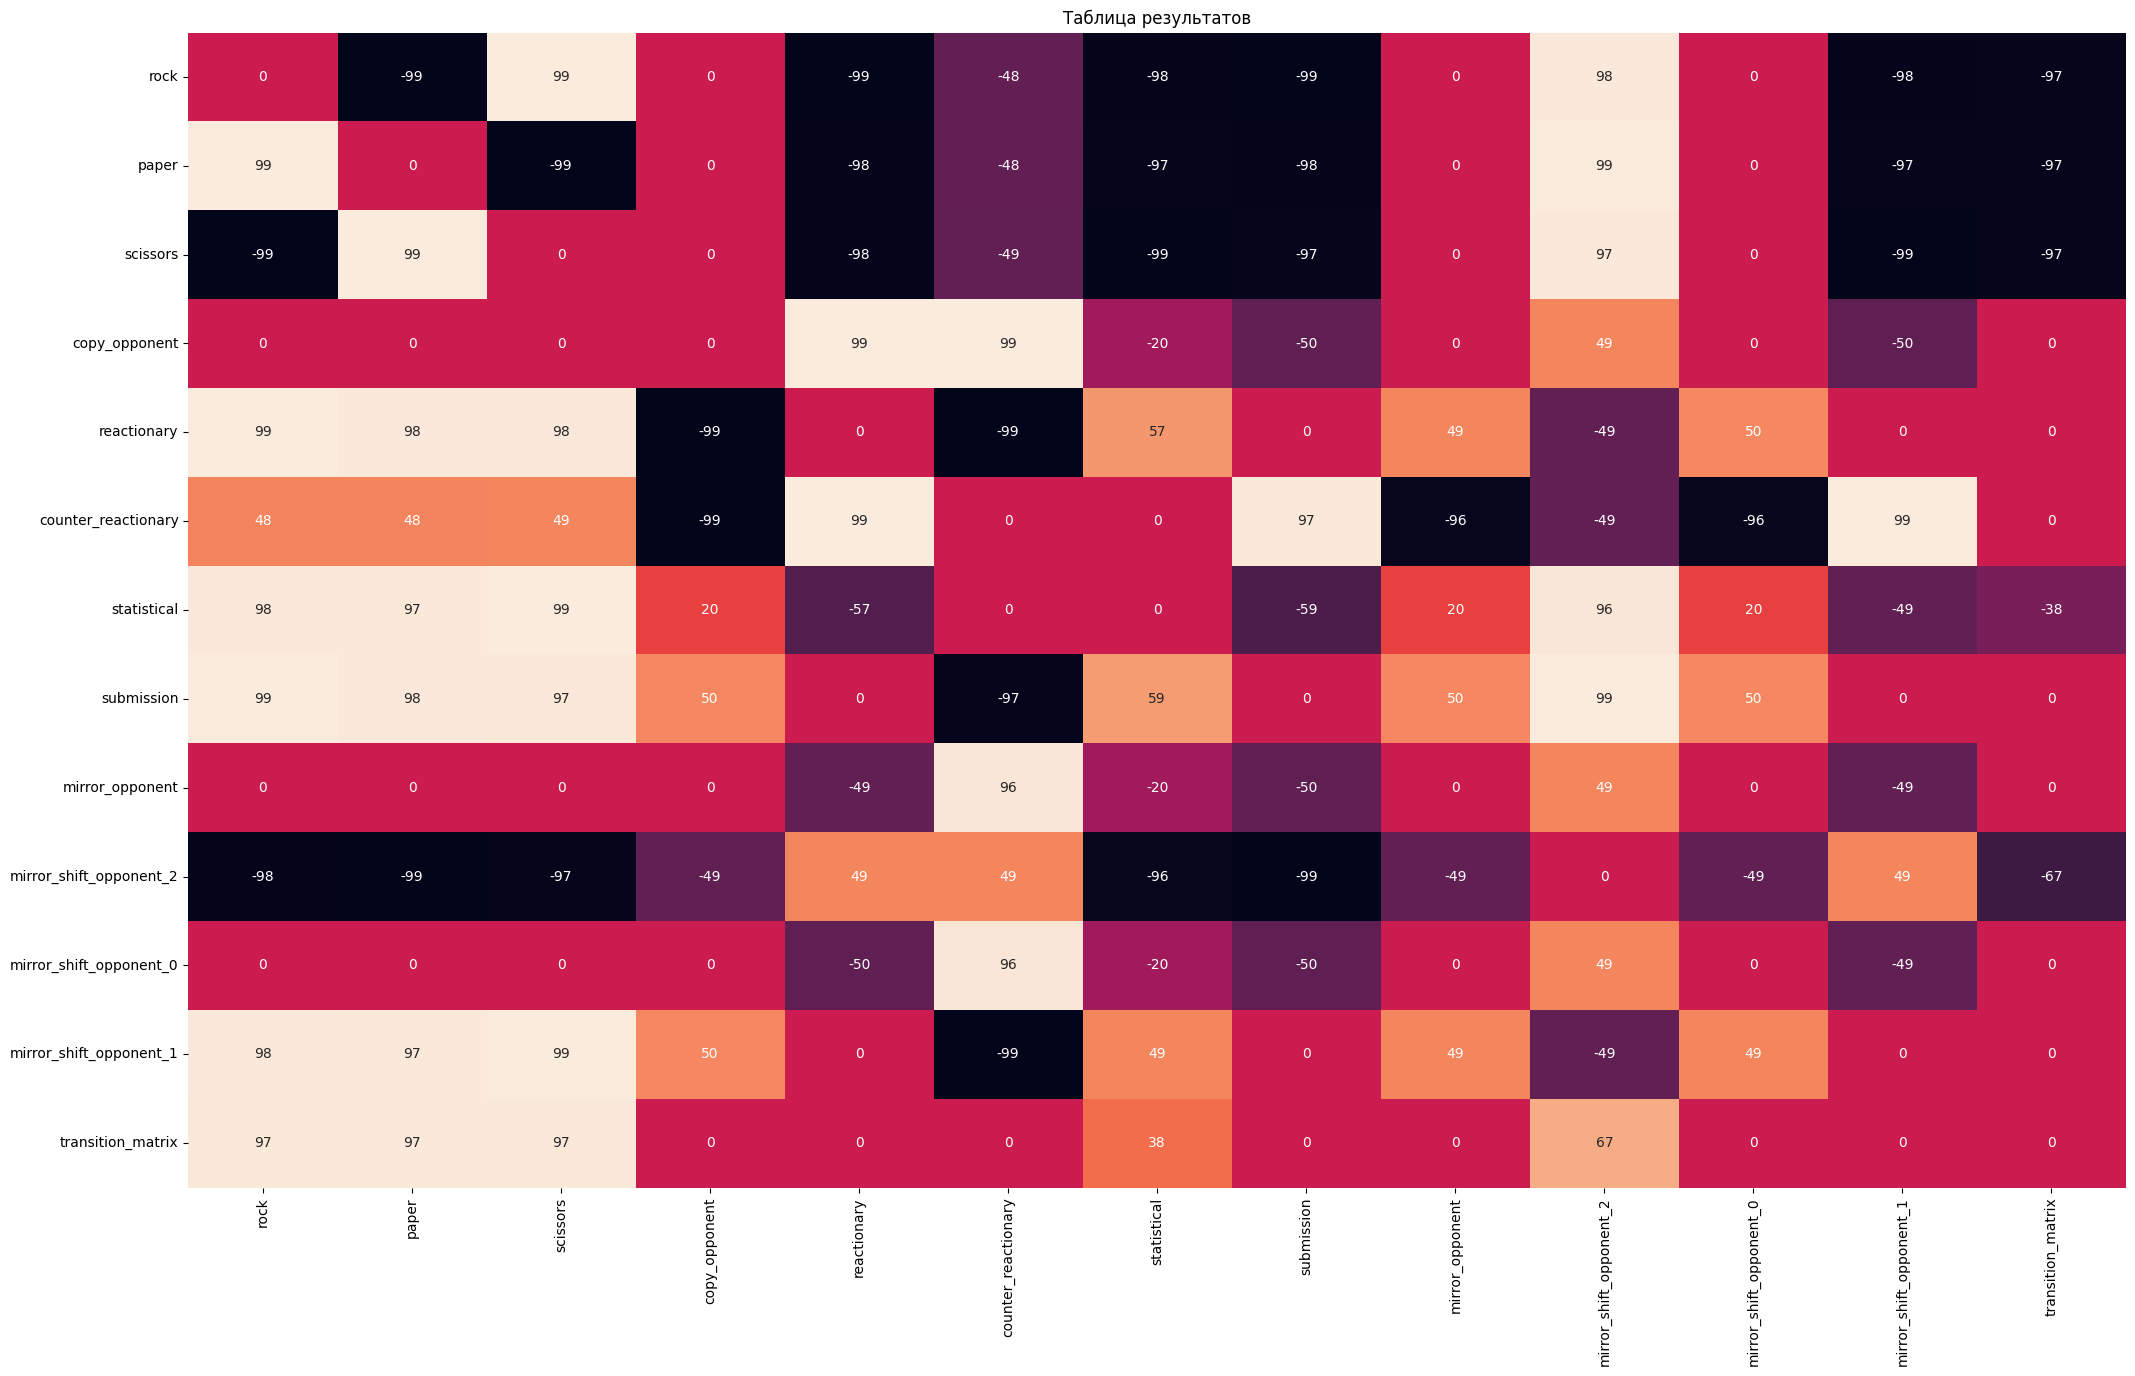

In [90]:
# Переименуем агентов немного, убрав расширение файла
names = [i.replace(".py", "") for i in agent_names]

interactions_matrix = \
interactions_matrix.set_axis(names, axis=0)
interactions_matrix = \
interactions_matrix.set_axis(names, axis=1)

# Визуализируем лидерборд через хитмап
fig, ax = plt.subplots(1, 1, figsize=(25, 15))

# Визуализируем хитмап
hm_plot = sns.heatmap(
    interactions_matrix,
    annot=True,
    cbar=False,
    ax=ax)

plt.title("Таблица результатов")
plt.show()

#### Вывод:
Наиболее оптимальной в плане пропорций выигрышей и проигрышей оказался агент на основе марковских цепей.